In [16]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [17]:
import os
import cv2  # or use PIL for image loading
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers, Model
import matplotlib.pyplot as plt

In [18]:
def preprocess_image(img):
    val = (img.astype('float32') - 127.5) / 127.5
    return val

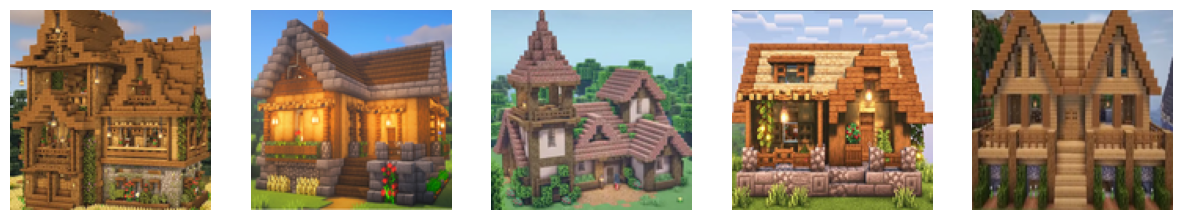

In [19]:

def load_and_preprocess_images(folder_path):
    # List all files in the folder
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))]

    num_samples = 5

    # Display sample images
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Read the image
        img = plt.imread(image_files[i])
    
        # Plot the image
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()
    
    # Load and preprocess each image
    images = []
    for file_path in image_files:
        img = cv2.imread(file_path)  # Load image using OpenCV
        # Perform preprocessing such as resizing, normalization, etc.
        img = preprocess_image(img)
        images.append(img)
    images = np.stack(images, axis=0)
    return images

# Load and preprocess images from a folder
folder_path = 'D:/NGUYEN/CV_ML/MinecraftHouse128'
images = load_and_preprocess_images(folder_path)

In [20]:
print(dataset.shape)

(96, 128, 128, 3)


In [21]:
# Define generator network
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(8*8*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


In [22]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

1/1 [==============================] - 0s 143ms/step


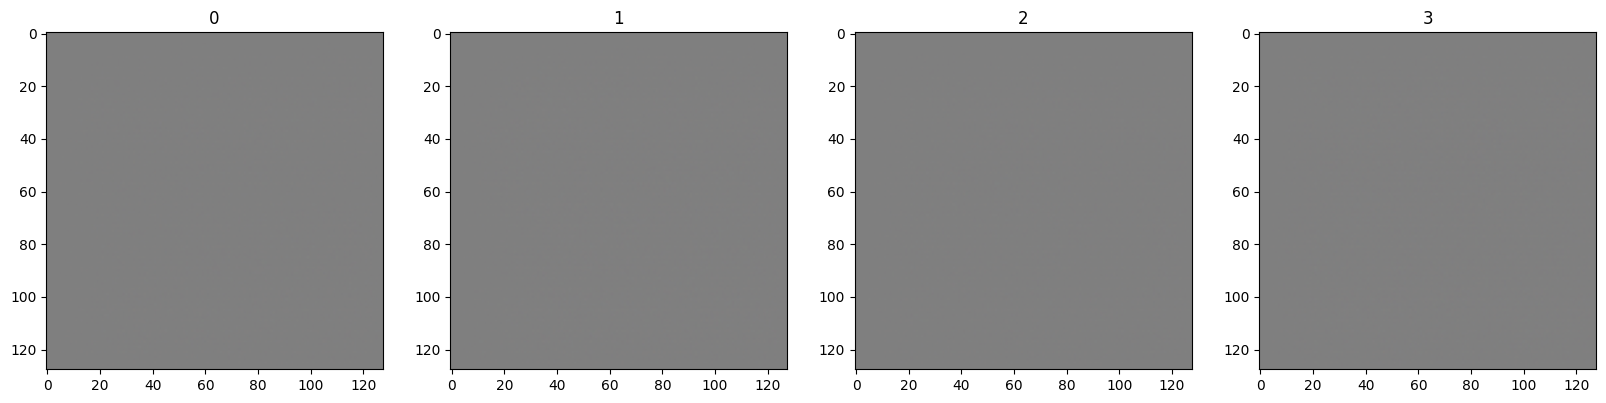

In [23]:
# Generate new fashion images
noise = np.random.randn(4, 100)  # Generate random noise
generated_images = generator.predict(noise)

# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Loop four times and get images
for idx, sample in enumerate(generated_images):
    # Plot the image using a specific subplot
    sample = (sample+1)/2.0
    ax[idx].imshow(sample)
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

plt.show()

In [42]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(128, 128, 3)),
        
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    
    return model

In [43]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                      

In [44]:
# Define GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    model = Model(gan_input, gan_output)
    return model

In [45]:
# Build networks
gan = build_gan(generator, discriminator)

In [46]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [52]:
def train(images, epochs, batch_size):
    gen_losses = []
    disc_losses = []
    
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0
        
        for image_batch in images:
            noise = tf.random.normal([batch_size, 100])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1

        avg_gen_loss = epoch_gen_loss / num_batches
        avg_disc_loss = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print(f"Epoch {epoch+1}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}")

        # Generate and save sample images every 10 epochs
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
    
    return gen_losses, disc_losses

In [48]:
# Function to generate and save sample images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        # Scale pixel values to range [0, 255] for each channel
        img = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        plt.subplot(8, 8, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [53]:
epochs = 100
batch_size = 32

# Load and preprocess the dataset
# Assuming `images` is your dataset

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(batch_size)

# Seed for generating sample images
seed = tf.random.normal([64, 100])

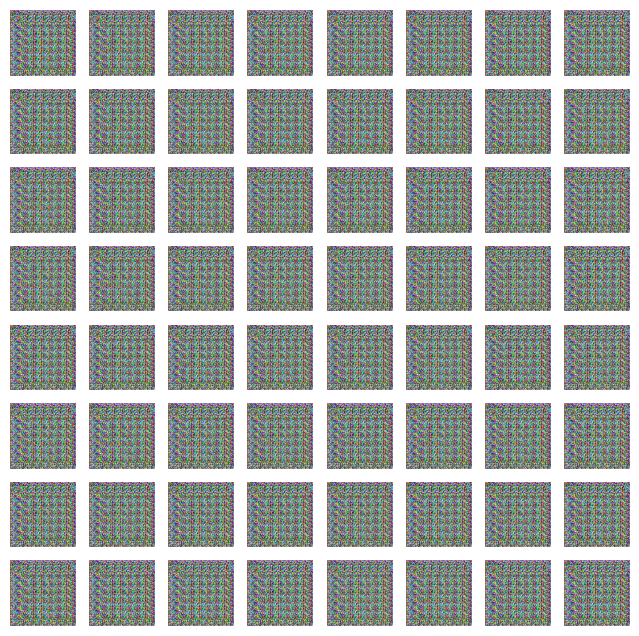

In [56]:
# Train the GAN
gen_losses, disc_losses = train(dataset, epochs, batch_size)

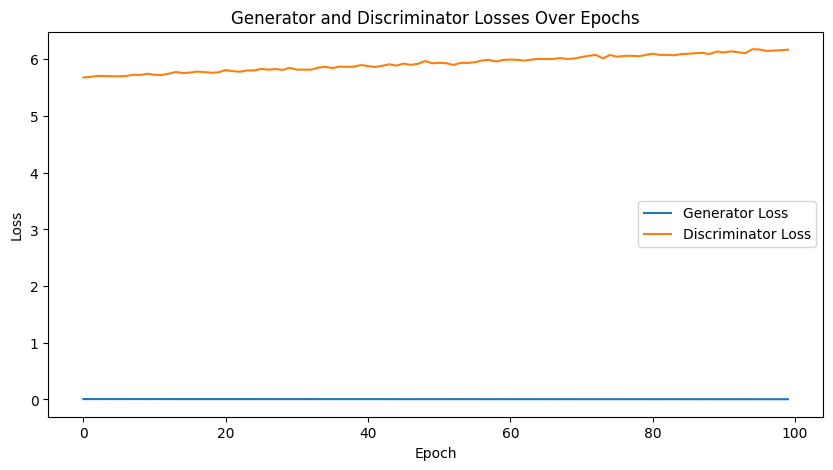

In [57]:
# Plot the generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Losses Over Epochs')
plt.show()
